In [ ]:
import random

class GridWorld:
    def __init__(self, grid_size=4, terminal_states=None, gamma=0.9):
        """
        Simple grid world environment.
        :param grid_size: Size of the grid (grid_size x grid_size).
        :param terminal_states: List of terminal states as (row, col).
        :param gamma: Discount factor.
        """
        self.grid_size = grid_size
        self.terminal_states = terminal_states or [(grid_size - 1, grid_size - 1)]
        self.gamma = gamma
        self.reset()

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = (0, 0)  # Start at top-left corner
        return self.agent_pos

    def step(self, action):
        """
        Take a step in the environment.
        :param action: Action to take (0=Up, 1=Right, 2=Down, 3=Left).
        :return: next_state, reward, done.
        """
        row, col = self.agent_pos
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # Up, Right, Down, Left
        dr, dc = moves[action]
        new_row = max(0, min(self.grid_size - 1, row + dr))
        new_col = max(0, min(self.grid_size - 1, col + dc))
        self.agent_pos = (new_row, new_col)

        if self.agent_pos in self.terminal_states:
            return self.agent_pos, 10, True  # Reward +10 for reaching terminal state
        return self.agent_pos, -1, False  # Step penalty -1

    def render(self):
        """Print the current state of the grid."""
        grid = [['.' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        for r, c in self.terminal_states:
            grid[r][c] = 'T'  # Mark terminal states
        row, col = self.agent_pos
        grid[row][col] = 'A'  # Mark agent position
        print("\n".join([" ".join(row) for row in grid]))
        print()


class MonteCarloControl:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        """
        Monte Carlo Control algorithm implementation.
        :param env: The environment object.
        :param gamma: Discount factor.
        :param epsilon: Exploration rate.
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}  # Action-value function Q(s, a)
        self.returns = {}  # Returns for state-action pairs
        self.policy = {}  # Policy π(s)

        for row in range(env.grid_size):
            for col in range(env.grid_size):
                state = (row, col)
                self.Q[state] = [0, 0, 0, 0]  # Initialize Q-values for all actions
                self.returns[state] = {a: [] for a in range(4)}  # Initialize returns
                self.policy[state] = [0.25, 0.25, 0.25, 0.25]  # Epsilon-greedy policy

    def epsilon_greedy(self, state):
        """Select an action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            return random.choice(range(4))  # Explore: random action
        return self.Q[state].index(max(self.Q[state]))  # Exploit: best action

    def generate_episode(self):
        """Generate an episode using the current policy."""
        episode = []
        state = self.env.reset()
        done = False
        while not done:
            action = self.epsilon_greedy(state)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def optimize_policy(self, num_episodes=1000):
        """Run Monte Carlo Control to optimize the policy."""
        for _ in range(num_episodes):
            episode = self.generate_episode()

            # Compute returns for the episode
            G = 0  # Initialize return
            visited = set()  # Track visited state-action pairs in this episode
            for state, action, reward in reversed(episode):
                G = reward + self.gamma * G
                if (state, action) not in visited:
                    visited.add((state, action))
                    self.returns[state][action].append(G)
                    self.Q[state][action] = sum(self.returns[state][action]) / len(self.returns[state][action])

            # Update the policy
            for state in self.policy:
                best_action = self.Q[state].index(max(self.Q[state]))
                for action in range(4):
                    if action == best_action:
                        self.policy[state][action] = 1 - self.epsilon + (self.epsilon / 4)
                    else:
                        self.policy[state][action] = self.epsilon / 4
        return self.policy


# Initialize environment and Monte Carlo Control
env = GridWorld(grid_size=4, terminal_states=[(3, 3)])
mc_control = MonteCarloControl(env)

# Run Monte Carlo Control
policy = mc_control.optimize_policy(num_episodes=1000)

# Display optimal policy
print("Optimal Policy (State -> Best Action):")
for state in sorted(mc_control.policy):
    best_action = mc_control.Q[state].index(max(mc_control.Q[state]))
    print(f"State {state}: Action {best_action}")

# Visualize environment
env.render()





Optimal Policy (State -> Best Action):
State (0, 0): Action 1
State (0, 1): Action 1
State (0, 2): Action 1
State (0, 3): Action 2
State (1, 0): Action 0
State (1, 1): Action 0
State (1, 2): Action 1
State (1, 3): Action 2
State (2, 0): Action 2
State (2, 1): Action 1
State (2, 2): Action 1
State (2, 3): Action 2
State (3, 0): Action 0
State (3, 1): Action 1
State (3, 2): Action 1
State (3, 3): Action 0
. . . .
. . . .
. . . .
. . . A



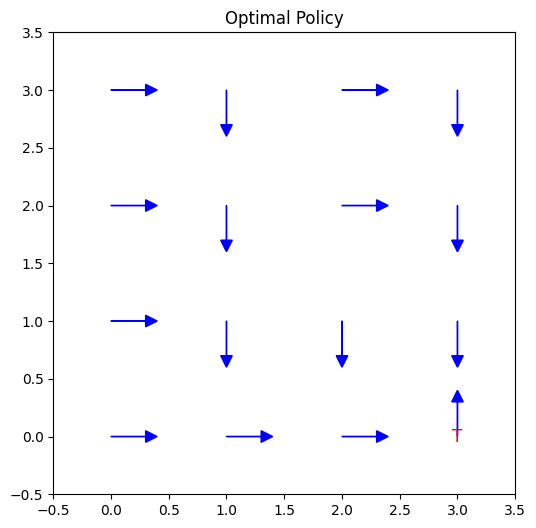

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Define the GridWorld environment
class GridWorld:
    def __init__(self, grid_size=4, terminal_states=None, gamma=0.9):
        self.grid_size = grid_size
        self.terminal_states = terminal_states or [(grid_size - 1, grid_size - 1)]
        self.gamma = gamma
        self.reset()

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = (0, 0)  # Start at the top-left corner
        return self.agent_pos

    def step(self, action):
        """
        Take a step in the environment.
        :param action: Action to take (0=Up, 1=Right, 2=Down, 3=Left).
        :return: next_state, reward, done.
        """
        row, col = self.agent_pos
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # Up, Right, Down, Left
        dr, dc = moves[action]
        new_row = max(0, min(self.grid_size - 1, row + dr))
        new_col = max(0, min(self.grid_size - 1, col + dc))
        self.agent_pos = (new_row, new_col)

        if self.agent_pos in self.terminal_states:
            return self.agent_pos, 10, True  # Reward +10 for reaching terminal state
        return self.agent_pos, -1, False  # Step penalty -1


# Monte Carlo methods for Prediction and Control
class MonteCarlo:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}  # Action-value function
        self.policy = {}  # Policy
        self.returns = {}  # Store all returns for (state, action)

        for row in range(env.grid_size):
            for col in range(env.grid_size):
                state = (row, col)
                self.Q[state] = np.zeros(4)  # Initialize Q-values for 4 actions
                self.policy[state] = np.ones(4) / 4  # Start with uniform random policy
                self.returns[state] = {action: [] for action in range(4)}

    def epsilon_greedy(self, state):
        """Choose an action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            return random.choice(range(4))  # Explore
        return np.argmax(self.Q[state])  # Exploit

    def generate_episode(self):
        """Generate an episode using the current policy."""
        state = self.env.reset()
        episode = []
        done = False

        while not done:
            action = self.epsilon_greedy(state)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        return episode

    def optimize_policy(self, num_episodes=5000):
        """Run Monte Carlo Control."""
        for _ in range(num_episodes):
            episode = self.generate_episode()
            G = 0
            visited = set()

            for state, action, reward in reversed(episode):
                G = reward + self.gamma * G
                if (state, action) not in visited:
                    visited.add((state, action))
                    self.returns[state][action].append(G)
                    self.Q[state][action] = np.mean(self.returns[state][action])

            # Update policy
            for state in self.policy.keys():
                best_action = np.argmax(self.Q[state])
                for action in range(4):
                    if action == best_action:
                        self.policy[state][action] = 1 - self.epsilon + (self.epsilon / 4)
                    else:
                        self.policy[state][action] = self.epsilon / 4

        return self.policy


# Visualization
def plot_policy(grid_size, policy):
    """
    Visualize the policy as arrows using Matplotlib.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    for row in range(grid_size):
        for col in range(grid_size):
            actions = policy[(row, col)]
            best_action = np.argmax(actions)

            if best_action == 0:  # Up
                dx, dy = 0, 0.3
            elif best_action == 1:  # Right
                dx, dy = 0.3, 0
            elif best_action == 2:  # Down
                dx, dy = 0, -0.3
            elif best_action == 3:  # Left
                dx, dy = -0.3, 0

            ax.arrow(col, grid_size - row - 1, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

    # Draw grid
    ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

    # Mark terminal state
    for terminal_state in env.terminal_states:
        row, col = terminal_state
        ax.text(col, grid_size - row - 1, 'T', ha='center', va='center', fontsize=12, color='red')

    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    ax.set_aspect('equal')
    ax.set_title("Optimal Policy")
    plt.show()


# Main
env = GridWorld(grid_size=4, terminal_states=[(3, 3)])
mc = MonteCarlo(env)

# Optimize the policy
optimal_policy = mc.optimize_policy(num_episodes=5000)

# Plot the optimal policy
plot_policy(env.grid_size, mc.policy)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


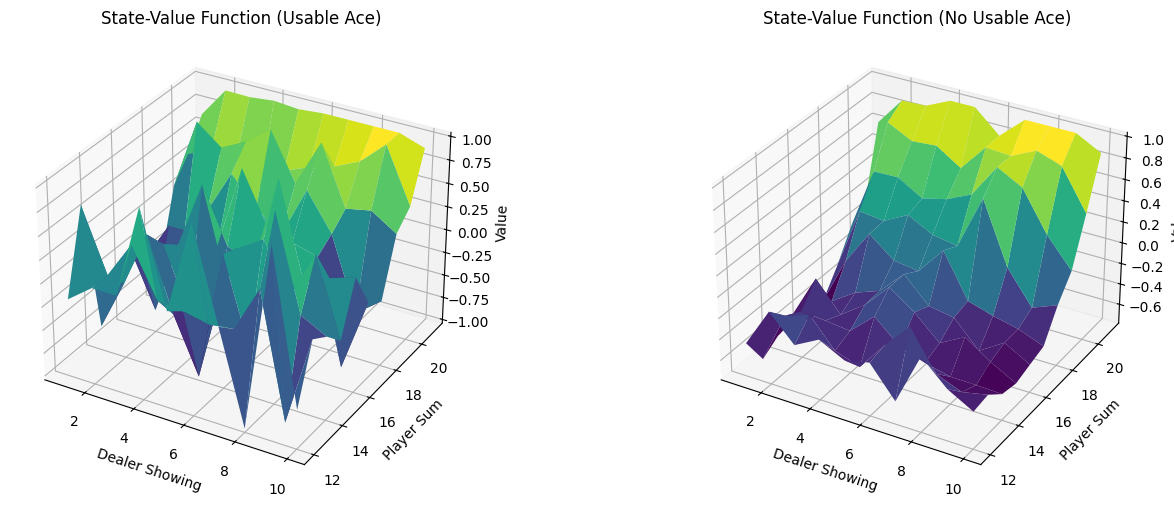

In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# Monte Carlo Control for Blackjack
class MonteCarloBlackjack:
    def __init__(self, env, gamma=1.0, epsilon=0.1):
        """
        Monte Carlo Control for Blackjack environment.
        :param env: Blackjack environment.
        :param gamma: Discount factor.
        :param epsilon: Exploration rate.
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
        self.returns = defaultdict(list)

    def epsilon_greedy(self, state):
        """
        Choose an action using epsilon-greedy policy.
        :param state: Current state.
        :return: Action (0=Stick, 1=Hit).
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Explore
        return np.argmax(self.Q[state])  # Exploit

    def generate_episode(self):
        """
        Generate an episode using the current policy.
        :return: List of (state, action, reward).
        """
        episode = []
        state = self.env.reset()
        done = False

        while not done:
            action = self.epsilon_greedy(state)
            next_state, reward, done, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        return episode

    def optimize_policy(self, num_episodes=10000):
        """
        Monte Carlo control to optimize the policy.
        :param num_episodes: Number of episodes to run.
        """
        for _ in range(num_episodes):
            episode = self.generate_episode()
            G = 0
            visited = set()

            for state, action, reward in reversed(episode):
                G = reward + self.gamma * G
                if (state, action) not in visited:
                    visited.add((state, action))
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] = np.mean(self.returns[(state, action)])

            # Update policy
            for state in self.policy.keys():
                best_action = np.argmax(self.Q[state])
                self.policy[state] = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
                self.policy[state][best_action] += 1 - self.epsilon


# Visualization Function
def plot_blackjack_values(V):
    """
    Plot the state-value function for Blackjack.
    :param V: State-value function.
    """
    player_sums = np.arange(12, 22)  # Player's sum from 12 to 21
    dealer_showing = np.arange(1, 11)  # Dealer's face-up card from 1 to 10
    usable_ace = np.zeros((len(player_sums), len(dealer_showing)))
    no_usable_ace = np.zeros((len(player_sums), len(dealer_showing)))

    for (player, dealer, ace), value in V.items():
        if 12 <= player <= 21:
            row = player - 12
            col = dealer - 1
            if ace:
                usable_ace[row, col] = value
            else:
                no_usable_ace[row, col] = value

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})
    x, y = np.meshgrid(dealer_showing, player_sums)

    # Plot with usable ace
    axs[0].plot_surface(x, y, usable_ace, cmap='viridis')
    axs[0].set_title('State-Value Function (Usable Ace)')
    axs[0].set_xlabel('Dealer Showing')
    axs[0].set_ylabel('Player Sum')
    axs[0].set_zlabel('Value')

    # Plot without usable ace
    axs[1].plot_surface(x, y, no_usable_ace, cmap='viridis')
    axs[1].set_title('State-Value Function (No Usable Ace)')
    axs[1].set_xlabel('Dealer Showing')
    axs[1].set_ylabel('Player Sum')
    axs[1].set_zlabel('Value')

    plt.show()


# Main Program
if __name__ == "__main__":
    # Initialize Blackjack environment
    env = gym.make('Blackjack-v1')
    mc_blackjack = MonteCarloBlackjack(env)

    # Optimize the policy using Monte Carlo Control
    mc_blackjack.optimize_policy(num_episodes=10000)

    # Derive state-value function from action-value function
    V = defaultdict(float)
    for state, actions in mc_blackjack.Q.items():
        V[state] = np.max(actions)  # State value is the maximum action value

    # Visualize the state-value function
    plot_blackjack_values(V)


Manual Display of State-Value Function:
Player Sum | Dealer Showing | Usable Ace | Value
-----------|----------------|------------|-------
     12    |       1         |     No      | -0.68
     12    |       1         |     Yes     | 0.00
     12    |       2         |     No      | -0.34
     12    |       2         |     Yes     | -1.00
     12    |       3         |     No      | -0.05
     12    |       3         |     Yes     | -0.50
     12    |       4         |     No      | -0.13
     12    |       4         |     Yes     | 0.33
     12    |       5         |     No      | 0.07
     12    |       5         |     Yes     | 1.00
     12    |       6         |     No      | 0.04
     12    |       6         |     Yes     | -1.00
     12    |       7         |     No      | -0.33
     12    |       7         |     Yes     | -1.00
     12    |       8         |     No      | -0.27
     12    |       8         |     Yes     | -0.33
     12    |       9         |     No      | -0.28

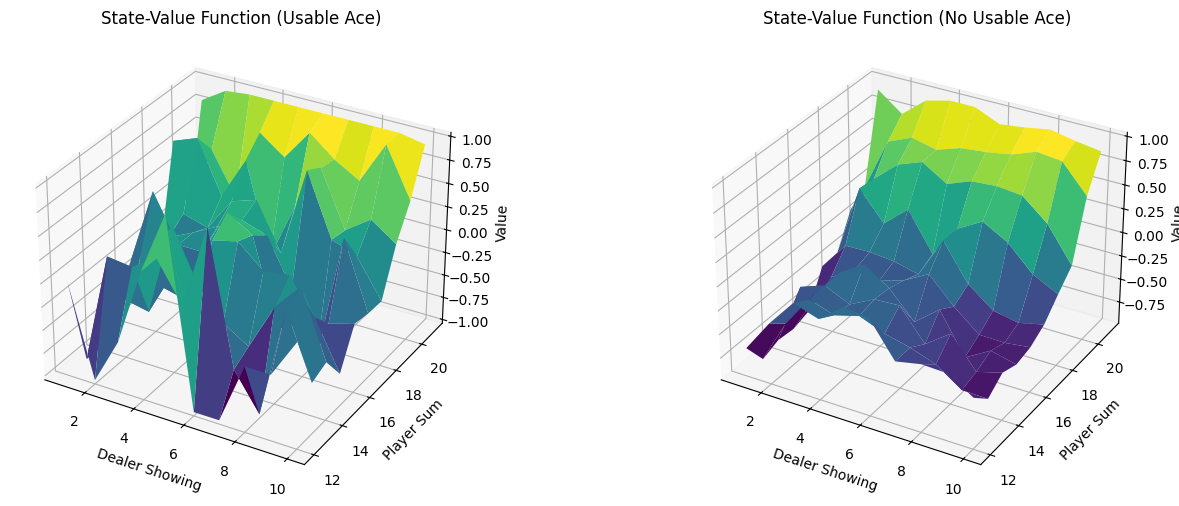

In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# Monte Carlo Control for Blackjack
class MonteCarloBlackjack:
    def __init__(self, env, gamma=1.0, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
        self.returns = defaultdict(list)

    def epsilon_greedy(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Explore
        return np.argmax(self.Q[state])  # Exploit

    def generate_episode(self):
        episode = []
        state = self.env.reset()
        done = False
        while not done:
            action = self.epsilon_greedy(state)
            next_state, reward, done, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def optimize_policy(self, num_episodes=10000):
        for _ in range(num_episodes):
            episode = self.generate_episode()
            G = 0
            visited = set()

            for state, action, reward in reversed(episode):
                G = reward + self.gamma * G
                if (state, action) not in visited:
                    visited.add((state, action))
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] = np.mean(self.returns[(state, action)])

            for state in self.policy.keys():
                best_action = np.argmax(self.Q[state])
                self.policy[state] = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
                self.policy[state][best_action] += 1 - self.epsilon


# Manual Display Function
def display_value_function(V):
    """
    Display the state-value function manually.
    :param V: State-value function.
    """
    print("Manual Display of State-Value Function:")
    print("Player Sum | Dealer Showing | Usable Ace | Value")
    print("-----------|----------------|------------|-------")
    for (player_sum, dealer_card, usable_ace), value in sorted(V.items()):
        if 12 <= player_sum <= 21:
            print(f"     {player_sum:<5} |       {dealer_card:<8}  |     {'Yes' if usable_ace else 'No':<6}  | {value:.2f}")


# Visualization Function
def plot_blackjack_values(V):
    player_sums = np.arange(12, 22)
    dealer_showing = np.arange(1, 11)
    usable_ace = np.zeros((len(player_sums), len(dealer_showing)))
    no_usable_ace = np.zeros((len(player_sums), len(dealer_showing)))

    for (player, dealer, ace), value in V.items():
        if 12 <= player <= 21:
            row = player - 12
            col = dealer - 1
            if ace:
                usable_ace[row, col] = value
            else:
                no_usable_ace[row, col] = value

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})
    x, y = np.meshgrid(dealer_showing, player_sums)

    axs[0].plot_surface(x, y, usable_ace, cmap='viridis')
    axs[0].set_title('State-Value Function (Usable Ace)')
    axs[0].set_xlabel('Dealer Showing')
    axs[0].set_ylabel('Player Sum')
    axs[0].set_zlabel('Value')

    axs[1].plot_surface(x, y, no_usable_ace, cmap='viridis')
    axs[1].set_title('State-Value Function (No Usable Ace)')
    axs[1].set_xlabel('Dealer Showing')
    axs[1].set_ylabel('Player Sum')
    axs[1].set_zlabel('Value')

    plt.show()


# Main Program
if __name__ == "__main__":
    env = gym.make('Blackjack-v1')
    mc_blackjack = MonteCarloBlackjack(env)

    # Optimize the policy
    mc_blackjack.optimize_policy(num_episodes=10000)

    # Derive state-value function from action-value function
    V = defaultdict(float)
    for state, actions in mc_blackjack.Q.items():
        V[state] = np.max(actions)

    # Manual display of state-value function
    display_value_function(V)

    # Visualize the state-value function
    plot_blackjack_values(V)


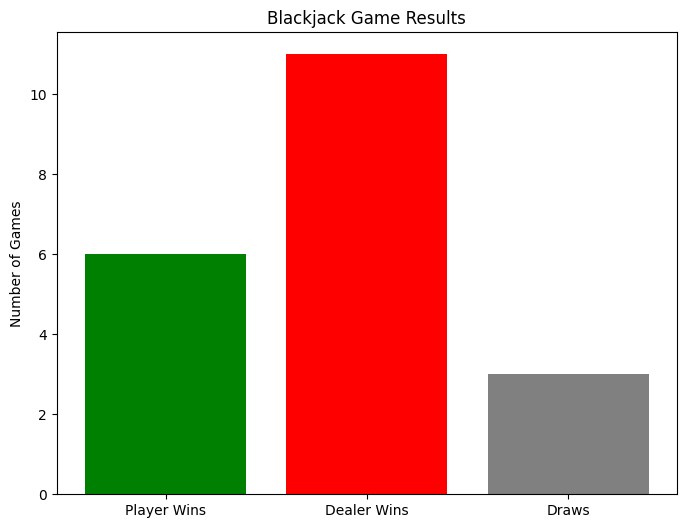

Game 1:
  States: [(7, 10, False), (17, 10, False), (27, 10, False)]
  Winner: Dealer
  Reward: -1.0

Game 2:
  States: [(14, 3, False), (17, 3, False), (27, 3, False)]
  Winner: Dealer
  Reward: -1.0

Game 3:
  States: [(12, 1, False), (16, 1, False), (17, 1, False), (22, 1, False)]
  Winner: Dealer
  Reward: -1.0

Game 4:
  States: [(21, 6, True), (21, 6, True)]
  Winner: Player
  Reward: 1.0

Game 5:
  States: [(13, 5, True), (18, 5, True), (18, 5, True)]
  Winner: Player
  Reward: 1.0

Game 6:
  States: [(20, 10, False), (20, 10, False)]
  Winner: Player
  Reward: 1.0

Game 7:
  States: [(17, 2, False), (25, 2, False)]
  Winner: Dealer
  Reward: -1.0

Game 8:
  States: [(15, 2, False), (19, 2, False), (19, 2, False)]
  Winner: Dealer
  Reward: -1.0

Game 9:
  States: [(9, 2, False), (11, 2, False), (12, 2, False), (17, 2, False), (22, 2, False)]
  Winner: Dealer
  Reward: -1.0

Game 10:
  States: [(20, 9, False), (20, 9, False)]
  Winner: Draw
  Reward: 0.0

Game 11:
  States: [(11

In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt


# Blackjack Simulator with Visualization
class BlackjackGame:
    def __init__(self):
        self.env = gym.make('Blackjack-v1')
        self.results = []

    def play_game(self, policy=None):
        """
        Play a single game of Blackjack.
        :param policy: A function mapping states to actions (optional). If None, use random actions.
        :return: Final state, reward, and the winner.
        """
        state = self.env.reset()
        done = False
        states = [state]

        while not done:
            if policy:
                action = policy(state)
            else:
                action = np.random.choice([0, 1])  # 0 = Stick, 1 = Hit (random action)

            next_state, reward, done, _ = self.env.step(action)
            states.append(next_state)
            state = next_state

        winner = "Player" if reward > 0 else "Dealer" if reward < 0 else "Draw"
        self.results.append({"states": states, "winner": winner, "reward": reward})
        return states, reward, winner

    def play_multiple_games(self, num_games=10, policy=None):
        """
        Play multiple games of Blackjack.
        :param num_games: Number of games to simulate.
        :param policy: A function mapping states to actions (optional).
        """
        for _ in range(num_games):
            self.play_game(policy)

    def visualize_results(self):
        """
        Visualize the results of multiple games.
        """
        player_wins = sum(1 for result in self.results if result["winner"] == "Player")
        dealer_wins = sum(1 for result in self.results if result["winner"] == "Dealer")
        draws = sum(1 for result in self.results if result["winner"] == "Draw")

        labels = ['Player Wins', 'Dealer Wins', 'Draws']
        counts = [player_wins, dealer_wins, draws]

        plt.figure(figsize=(8, 6))
        plt.bar(labels, counts, color=['green', 'red', 'gray'])
        plt.title("Blackjack Game Results")
        plt.ylabel("Number of Games")
        plt.show()

    def print_game_details(self):
        """
        Print the details of each game played.
        """
        for i, result in enumerate(self.results, 1):
            print(f"Game {i}:")
            print(f"  States: {result['states']}")
            print(f"  Winner: {result['winner']}")
            print(f"  Reward: {result['reward']}")
            print()


# Main Program
if __name__ == "__main__":
    blackjack = BlackjackGame()

    # Define a simple policy: Stick if player_sum >= 18, otherwise Hit
    def simple_policy(state):
        player_sum, dealer_card, usable_ace = state
        return 0 if player_sum >= 18 else 1

    # Play multiple games
    blackjack.play_multiple_games(num_games=20, policy=simple_policy)

    # Visualize the results
    blackjack.visualize_results()

    # Print detailed outcomes
    blackjack.print_game_details()
